# Asset Pricing Homework

Natasha Watkins

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import broyden1, minimize
from fredapi import Fred
fred = Fred(api_key='16fc433e0cb217bb8cb94bf76b981f2f')

### Exercises Part 1

Problem 1)

In [2]:
β = 0.99

In [3]:
c = fred.get_series('PCECC96')            # Real personal consumption expenditures
gdp_deflator = fred.get_series('GDPDEF')  # GDP deflator
index = fred.get_series('WILL5000INDFC')  # Return to US stock market
riskfree = fred.get_series('TB3MS')       # Risk-free rate

In [4]:
index = index.resample('QS').first()      # Resample to quarterly data
rf = riskfree.resample('QS').first() / 100

In [5]:
gdp_deflator = gdp_deflator.resample('QS').first()
real_index = index / (gdp_deflator)
R = (real_index - real_index.shift(1)) / real_index + 1  # Calculate gross quarterly real returns

In [6]:
# Resample data to equal length
start_year = '1971'
end_year = '2017'
R = R[start_year:end_year]
c = c[start_year:end_year]
rf = rf[start_year:end_year]

In [7]:
def objective(β, c, R, γ):
    mc = c**(-γ)
    m = β * mc / mc.shift(1)
    m = m[1:]
    R = R[1:]
    covariance = np.cov(m, R)[0, 1]
    return 1 - covariance - m.mean() * R.mean()

In [8]:
# Evaluate function partially
objective_partial = partial(objective, β, c, R)

# Find root of objective function
broyden1(objective_partial, 2)

array(0.42687205)

Problem 3)

In [9]:
def objective2(β, c, rf, γ):
    mc = c**(-γ)
    m = β * mc / mc.shift(1)
    rf = rf[0]
    return 1 + rf - 1 / np.mean(m[1:])

In [10]:
objective2_partial = partial(objective2, β, c, rf)

broyden1(objective2_partial, 2)

array(4.51842318)

Problem 4)

In this problem, we will aim to minimise the moments, rather than find their root.

In [11]:
def objective3(params, c, R, rf):
    
    γ, β = params
    
    moments = np.empty(2)
    W = np.eye(2)
    
    mc = c**(-γ)
    m = β * mc / mc.shift(1)
    
    m = m[1:]
    R = R[1:]
    covariance = np.cov(m, R)[0, 1]
    moments[0] = 1 - covariance - m.mean() * R.mean()
    
    rf = rf[0]
    moments[1] = 1 + rf - 1 / np.mean(m)
    
    return moments.T @ W @ moments

In [12]:
γ_gmm, β_gmm = minimize(objective3, [2, 2], args=(c, R, rf)).x
γ_gmm, β_gmm

(2.0152156746660737, 0.9862077167829368)

In [13]:
n = 60
N = 5
γ_grid = np.linspace(0, 5, n)
β_grid = np.linspace(0.95, 0.99, N)

gmm_values = np.empty((n, N))
for i in range(n):
    for j in range(N):
        gmm_values[i, j] = objective3((γ_grid[i], β_grid[j]), c, R, rf)

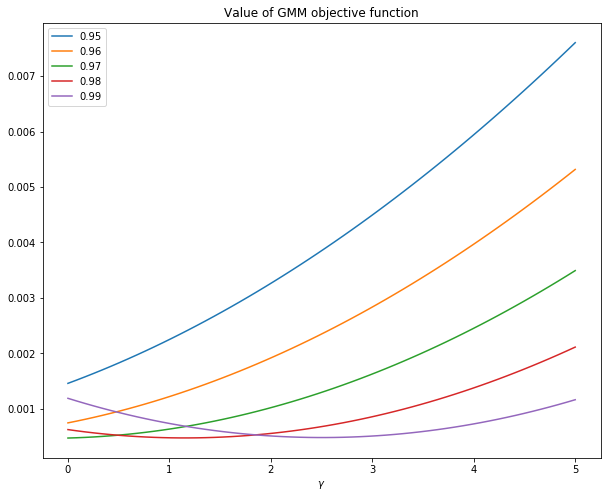

In [14]:
plt.figure(figsize=(10, 8))
for j in range(N):
    plt.plot(γ_grid, gmm_values[:, j], label=f'{β_grid[j]:.2f}')
plt.title('Value of GMM objective function')
plt.xlabel('$\gamma$')
plt.legend()
plt.show()